In [ ]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from library.nn.conv import ResNet
from library.callbacks import TrainingMonitor
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.datasets import cifar10
import numpy as np
import os

In [ ]:
model_path = ".\\output\\resnet_cifar10.hdf5"

output_path = ".\\output"

# define the total number of epochs to train for along with the
# initial learning rate
NUM_EPOCHS = 100
INIT_LR = 1e-1

In [ ]:
def poly_decay(epoch):
	# initialize the maximum number of epochs, base learning rate,
	# and power of the polynomial
	maxEpochs = NUM_EPOCHS
	baseLR = INIT_LR
	power = 1.0

	# compute the new learning rate based on polynomial decay
	alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power

	# return the new learning rate
	return alpha

In [ ]:
# load the training and testing data, converting the images from
# integers to floats
print("[INFO] loading CIFAR-10 data...")
((trainX, trainY), (testX, testY)) = cifar10.load_data()
trainX = trainX.astype("float")
testX = testX.astype("float")

# apply mean subtraction to the data
mean = np.mean(trainX, axis=0)
trainX -= mean
testX -= mean

# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

# construct the image generator for data augmentation
aug = ImageDataGenerator(width_shift_range=0.1,
	height_shift_range=0.1, horizontal_flip=True,
	fill_mode="nearest")

# construct the set of callbacks
figPath = os.path.sep.join([output_path, "{}.png".format(
	os.getpid())])
jsonPath = os.path.sep.join([output_path, "{}.json".format(
	os.getpid())])
callbacks = [TrainingMonitor(figPath, jsonPath=jsonPath),
	LearningRateScheduler(poly_decay)]

# initialize the optimizer and model (ResNet-56)
print("[INFO] compiling model...")
opt = SGD(lr=INIT_LR, momentum=0.9)
model = ResNet.build(32, 32, 3, 10, (9, 9, 9),
	(64, 64, 128, 256), reg=0.0005)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

In [ ]:
# train the network
print("[INFO] training network...")
model.fit_generator(
	aug.flow(trainX, trainY, batch_size=128),
	validation_data=(testX, testY),
	steps_per_epoch=len(trainX) // 128, epochs=NUM_EPOCHS,
	callbacks=callbacks, verbose=1)

In [ ]:
# save the network to disk
print("[INFO] serializing network...")
model.save(model_path)

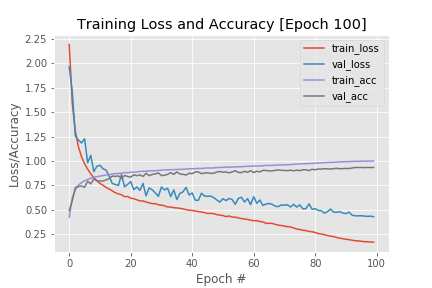

In [1]:
from IPython.display import Image
Image(filename='5916.png')